<a href="https://colab.research.google.com/github/oakfr/nn-training/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving names.txt to names.txt


In [10]:
# read the data
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [21]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [22]:
block_size = 3

def build_dataset(words):
  # build dataset
  X = []
  Y = []

  for w in words:
    context = [0] * block_size
    for c in w + '.':
      ix = stoi[c]
      Y.append(ix)
      X.append(context)
      #print(''.join([itos[i] for i in context]), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [23]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [48]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size,n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
parameters = [C, W1, b1, W2, b2]

In [49]:
for p in parameters:
  p.requires_grad = True

In [51]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad 

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 2.2719
  10000/ 200000: 2.0326
  20000/ 200000: 1.9983
  30000/ 200000: 2.4017
  40000/ 200000: 2.2712
  50000/ 200000: 2.0150
  60000/ 200000: 1.9887
  70000/ 200000: 2.0578
  80000/ 200000: 2.4542
  90000/ 200000: 2.2055
 100000/ 200000: 2.1818
 110000/ 200000: 2.3820
 120000/ 200000: 2.0930
 130000/ 200000: 2.3533
 140000/ 200000: 2.0753
 150000/ 200000: 2.0603
 160000/ 200000: 2.1912
 170000/ 200000: 1.8862
 180000/ 200000: 2.0456
 190000/ 200000: 1.9323
1.9408866167068481


In [52]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  return loss
  
print(split_loss('train'))
print(split_loss('dev'))

tensor(2.0313)
tensor(2.1027)


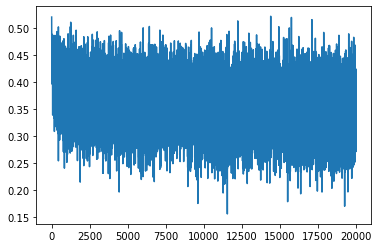

In [43]:
plt.plot(lossi)

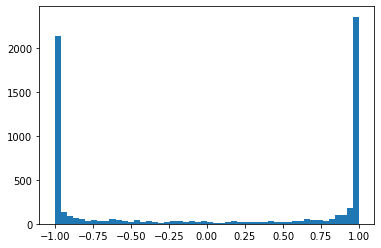

In [47]:
plt.hist(h.view(-1).tolist(),50);

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  context = [0] * block_size

  out = []

  while True:

    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
    
  word = ''.join([itos[i] for i in out])
  print(word)



carmahzati.
hella.
jalixalety.
halaysa.
jazonen.
delyah.
jaleni.
nelania.
chaiiv.
elle.
gyd.
lio.
din.
quinn.
sulinea.
jamilairaero.
dearisi.
jameendredy.
emmedi.
abetteferia.
